In [4]:
import numpy as np
import pandas as pd

import GPUtil
# #imports from python 3.8
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import skew
from joblib import dump, load


In [ ]:
import subprocess

def get_gpu_details():
    try:
        result = subprocess.run(['nvidia-smi'], capture_output=True)
        output = result.stdout.decode('utf-8')
        print(output)
    except FileNotFoundError:
        print("nvidia-smi not found. Please make sure NVIDIA drivers are installed.")

# Call the function to display GPU details
get_gpu_details()

In [6]:
# pip install torch 

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ",device)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# export CUDA_VISIBLE_DEVICES=0
GPUtil.getAvailable()
# use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
else:
    print("None")


print(tf.config.list_physical_devices('GPU'))

Device:  cpu
Num GPUs Available:  0
None
[]


In [2]:
df = pd.read_csv('./data/df_final.csv')

X_train_final = pd.read_csv('./data/X_train_final.csv')
Y_train_final = pd.read_csv('./data/Y_train_final.csv')
X_test = pd.read_csv('./data/X_test.csv')
Y_test = pd.read_csv('./data/Y_test.csv')
X_val = pd.read_csv('./data/X_val.csv')
Y_val = pd.read_csv('./data/Y_val.csv')

In [3]:
print("Train set shapes:", X_train_final.shape, Y_train_final.shape)
print("Test set shapes:", X_test.shape, Y_test.shape)
print("Validation set shapes:", X_val.shape, Y_val.shape)

Train set shapes: (48000, 1) (48000, 1)
Test set shapes: (16267, 1) (16267, 1)
Validation set shapes: (16267, 1) (16267, 1)


# HyperParams


In [12]:
# Model Parameters
BATCH_SIZE = 100
INPUT_DIM = (150, 150, 3)  # RGB - 3 channels images
OUTPUT_CLASSES = 6  # One-hot encoded: 8 different classes

# Training Parameters
EPOCHS = 32
LEARNING_RATE = 1e-2
MOMENTUM = 0.9

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(4, (4, 4), activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(8, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
    tf.keras.layers.GlobalMaxPool2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5, seed=42),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
], name='clf-cnn')

model.compile(
    optimizer=RMSprop(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy'],
)

In [24]:
model.summary()

Model: "clf-cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 147, 147, 4)       196       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 73, 73, 4)        0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 70, 70, 8)         520       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 35, 35, 8)        0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 16)        2064      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 16)       0   

# Train Set


In [25]:
merged_train_df = pd.concat([X_train_final, Y_train_final], axis=1)
# merged_train_df.to_csv('./data/merged_train.csv', index = False)


In [26]:
# Ensure 'ImgPath' column is of string type
Y_train_final['Class'] = Y_train_final['Class'].astype(str)
# train['ImgPath'] = train['ImgPath'].astype(str)
dir = './testing/'
# Initialize ImageDataGenerator

train_datagen = ImageDataGenerator(data_format='channels_last', rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                       height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# Flow from merged DataFrame with full image paths
train_generator = train_datagen.flow_from_dataframe(
    dataframe=merged_train_df,
    x_col='ImgPath',
    y_col='Class',
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42,
)

Found 47999 validated image filenames belonging to 6 classes.


C:\Users\LENOVO\anaconda3\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="ImgPath". These filename(s) will be ignored.
  warnings.warn(


# Validation Set

In [27]:
merged_val_df = pd.concat([X_val, Y_val], axis=1)

In [28]:
Y_val['Class'] = Y_val['Class'].astype(str)
# X_val
merged_val_df = pd.concat([X_val, Y_val], axis=1)

# Initialize ImageDataGenerator
val_datagen = ImageDataGenerator(data_format='channels_last', rescale=1./255)

# merged_val_df = pd.concat([X_val, Y_val], axis=2)

# Flow from merged DataFrame with full image paths
val_generator = val_datagen.flow_from_dataframe(
    dataframe=merged_val_df,
    # directory= df,
    x_col='ImgPath',
    y_col='Class',
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

Found 16267 validated image filenames belonging to 6 classes.


In [29]:
log_dir = "./logs/"
with tf.device('GPU:0'):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=False)
    history = model.fit(
        train_generator, validation_data=val_generator,
        epochs=EPOCHS,
        steps_per_epoch=merged_train_df.shape[0] // BATCH_SIZE,
        validation_steps=merged_val_df.shape[0] // BATCH_SIZE,
        verbose=1, callbacks=[tensorboard_callback],
    )

Epoch 1/32
480/480 [==============================] - 288s 598ms/step - loss: 1.9180 - categorical_accuracy: 0.1657 - val_loss: 1.9066 - val_categorical_accuracy: 0.2580
Epoch 2/32
480/480 [==============================] - 277s 577ms/step - loss: 1.8695 - categorical_accuracy: 0.1672 - val_loss: 1.9470 - val_categorical_accuracy: 0.2071
Epoch 3/32
480/480 [==============================] - 275s 573ms/step - loss: 1.8365 - categorical_accuracy: 0.1658 - val_loss: 1.7998 - val_categorical_accuracy: 0.0924
Epoch 4/32
480/480 [==============================] - 276s 574ms/step - loss: 1.8338 - categorical_accuracy: 0.1647 - val_loss: 1.9482 - val_categorical_accuracy: 0.0475
Epoch 5/32
480/480 [==============================] - 273s 568ms/step - loss: 1.8313 - categorical_accuracy: 0.1634 - val_loss: 1.8476 - val_categorical_accuracy: 0.2073
Epoch 6/32
480/480 [==============================] - 274s 570ms/step - loss: 1.8332 - categorical_accuracy: 0.1663 - val_loss: 1.7622 - val_categoric

In [30]:
model.save('CNN1.h5')

In [50]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(4, (4, 4), activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(8, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
    tf.keras.layers.GlobalMaxPool2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
], name='clf-cnn')

model.compile(
    optimizer=RMSprop(learning_rate=1e-1, momentum=MOMENTUM),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy'],
)


log_dir = "./logs1/"
with tf.device('GPU:0'):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=False)
    history = model.fit(
        train_generator, validation_data=val_generator,
        epochs=EPOCHS,
        steps_per_epoch=merged_train_df.shape[0] // BATCH_SIZE,
        validation_steps=merged_val_df.shape[0] // BATCH_SIZE,
        verbose=1, callbacks=[tensorboard_callback],
    )
model.save('CNN2.h5')

Epoch 1/32
480/480 [==============================] - 313s 650ms/step - loss: 19.5133 - categorical_accuracy: 0.1671 - val_loss: 10.3525 - val_categorical_accuracy: 0.3168
Epoch 2/32
480/480 [==============================] - 290s 603ms/step - loss: 19.2264 - categorical_accuracy: 0.1661 - val_loss: 13.7066 - val_categorical_accuracy: 0.0784
Epoch 3/32
480/480 [==============================] - 288s 599ms/step - loss: 18.1352 - categorical_accuracy: 0.1681 - val_loss: 12.3739 - val_categorical_accuracy: 0.2586
Epoch 4/32
480/480 [==============================] - 290s 604ms/step - loss: 19.3685 - categorical_accuracy: 0.1680 - val_loss: 32.5254 - val_categorical_accuracy: 0.0475
Epoch 5/32
480/480 [==============================] - 289s 601ms/step - loss: 15.0348 - categorical_accuracy: 0.1661 - val_loss: 17.2237 - val_categorical_accuracy: 0.2585
Epoch 6/32
480/480 [==============================] - 294s 613ms/step - loss: 16.8318 - categorical_accuracy: 0.1695 - val_loss: 8.1040 - va

In [51]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(4, (4, 4), activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(8, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
    tf.keras.layers.GlobalMaxPool2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
], name='clf-cnn')

model.compile(
    optimizer=RMSprop(learning_rate=1, momentum=MOMENTUM),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy'],
)


log_dir = "./logs1/"
with tf.device('GPU:0'):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=False)
    history = model.fit(
        train_generator, validation_data=val_generator,
        epochs=EPOCHS,
        steps_per_epoch=merged_train_df.shape[0] // BATCH_SIZE,
        validation_steps=merged_val_df.shape[0] // BATCH_SIZE,
        verbose=1, callbacks=[tensorboard_callback],
    )
model.save('CNN3.h5')

Epoch 1/32
480/480 [==============================] - 294s 611ms/step - loss: 222.5292 - categorical_accuracy: 0.1667 - val_loss: 85.9089 - val_categorical_accuracy: 0.3164
Epoch 2/32
480/480 [==============================] - 291s 607ms/step - loss: 234.9460 - categorical_accuracy: 0.1656 - val_loss: 500.3441 - val_categorical_accuracy: 0.0928
Epoch 3/32
480/480 [==============================] - 291s 607ms/step - loss: 215.9897 - categorical_accuracy: 0.1640 - val_loss: 309.6551 - val_categorical_accuracy: 0.0923
Epoch 4/32
480/480 [==============================] - 291s 606ms/step - loss: 219.1307 - categorical_accuracy: 0.1686 - val_loss: 173.3013 - val_categorical_accuracy: 0.0475
Epoch 5/32
480/480 [==============================] - 294s 611ms/step - loss: 237.9630 - categorical_accuracy: 0.1653 - val_loss: 245.3688 - val_categorical_accuracy: 0.0785
Epoch 6/32
480/480 [==============================] - 328s 683ms/step - loss: 218.2495 - categorical_accuracy: 0.1631 - val_loss: 4

KeyboardInterrupt: 

### Huan Test

In [ ]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_DIM),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(32, (4, 4), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
#     tf.keras.layers.GlobalMaxPool2D(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(128, activation='sigmoid'),
#     tf.keras.layers.Dense(OUTPUT_CLASSES),
# ], name='clf-cnn')

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

num_categories = 6
model = tf.keras.Sequential([
        # Convolutional layer learning 32 filters with a kernel size of 3x3
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
         tf.keras.layers.MaxPooling2D(2, 2),
        # Second convolutional layer with 64 filters
         tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
         tf.keras.layers.MaxPooling2D(2, 2),
        # Third convolutional layer with 128 filters
         tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
         tf.keras.layers.MaxPooling2D(2, 2),
        # Flatten the results to feed into a DNN
         tf.keras.layers.Flatten(),
        # 512 neuron hidden layer
         tf.keras.layers.Dense(512, activation='relu'),
         tf.keras.layers.Dropout(0.5),
        # Output layer with one neuron per category
         tf.keras.layers.Dense(num_categories, activation='softmax')
    ])
    
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                       height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)


# Flow from merged DataFrame with full image paths
train_generator = train_datagen.flow_from_dataframe(
    dataframe=merged_train_df,
    x_col='ImgPath',
    y_col='Class',
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42,
)

# Flow from merged DataFrame with full image paths
val_generator = val_datagen.flow_from_dataframe(
    dataframe=merged_val_df,
    # directory= df,
    x_col='ImgPath',
    y_col='Class',
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

# train_generator = train_datagen.flow_from_directory(
#     target_size=(128, 128),
#     batch_size=32,
#     class_mode='categorical')

# validation_generator = val_datagen.flow_from_directory(
#     target_size=(128, 128),
#     batch_size=32,
#     class_mode='categorical')

Found 47999 validated image filenames belonging to 6 classes.


C:\Users\LENOVO\anaconda3\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="ImgPath". These filename(s) will be ignored.
  warnings.warn(


Found 16267 validated image filenames belonging to 6 classes.


In [54]:
# Train the model
log_dir = "./CNN/log_model1"
with tf.device('GPU:0'):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=False)
    history = model.fit(
        train_generator,
        steps_per_epoch=100,  # depends on the size of your training set
        epochs=30,
        validation_data=val_generator,
        validation_steps=50)  # depends on the size of your validation set

# Save the model
model.save('model1.h5')


Epoch 1/30
100/100 [==============================] - 94s 934ms/step - loss: 1.5802 - accuracy: 0.3469 - val_loss: 1.3864 - val_accuracy: 0.5458
Epoch 2/30
100/100 [==============================] - 85s 853ms/step - loss: 1.2977 - accuracy: 0.4742 - val_loss: 0.9701 - val_accuracy: 0.6460
Epoch 3/30
100/100 [==============================] - 83s 828ms/step - loss: 1.1575 - accuracy: 0.5381 - val_loss: 1.0316 - val_accuracy: 0.6560
Epoch 4/30
100/100 [==============================] - 83s 824ms/step - loss: 1.0754 - accuracy: 0.5820 - val_loss: 0.8088 - val_accuracy: 0.7062
Epoch 5/30
100/100 [==============================] - 106s 1s/step - loss: 1.0131 - accuracy: 0.6084 - val_loss: 0.7790 - val_accuracy: 0.7236
Epoch 6/30
100/100 [==============================] - 114s 1s/step - loss: 0.9421 - accuracy: 0.6461 - val_loss: 0.6637 - val_accuracy: 0.7656
Epoch 7/30
100/100 [==============================] - 103s 1s/step - loss: 0.9042 - accuracy: 0.6576 - val_loss: 0.6626 - val_accuracy

In [58]:
def plot_learning_curve(
        train_loss, val_loss, train_metric, val_metric,
        to_file: str = None
) -> None:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].plot(train_loss, 'r--')
    ax[0].plot(val_loss, 'b--')
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend(['train', 'val'])

    ax[1].plot(train_metric, 'r--')
    ax[1].plot(val_metric, 'b--')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].axhline(y=0.125, c='g', alpha=0.5)  # Random probability - naive classifier
    ax[1].legend(['train', 'val', 'random baseline'])

    fig.tight_layout()
    plt.show()
    if to_file is not None:
        fig.savefig(to_file)

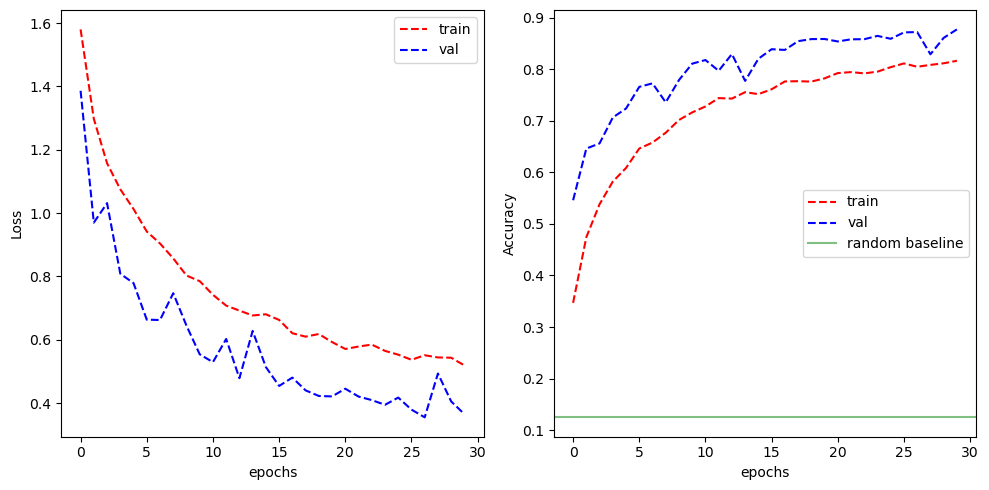

In [59]:
plot_name = 'clf-cnn'
plot_learning_curve(
    history.history['loss'],
    history.history['val_loss'],
    history.history['accuracy'],
    history.history['val_accuracy'],
    to_file=f'images/{plot_name}-LearningCurve.png'
)

## Test data

In [5]:
X_test = pd.read_csv('./data/X_test.csv')
Y_test = pd.read_csv('./data/Y_test.csv')
merged_test_df = pd.concat([X_test, Y_test], axis=1)
test_datagen = ImageDataGenerator(data_format='channels_last', rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=merged_test_df,
    x_col='ImgPath',
    y_col='Class',
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    seed=42
)

Found 16267 validated image filenames belonging to 6 classes.


In [70]:
with tf.device('GPU:0'):
    # Evaluate the model on the test data using the test generator
    loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))
    
    # Print the test accuracy
    print('Test accuracy:', accuracy)

16267/16267 [==============================] - 72s 4ms/step - loss: 0.3722 - accuracy: 0.8761
Test accuracy: 0.8761295676231384


In [8]:
model = tf.keras.models.load_model('model1.h5')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 17, 17, 128)     

In [9]:
# Fetch 10 random batches from the test generator
random_images = []
random_truths = []
random_predictions = []

for i in range(10):
    # Obtain a batch (since batch_size=1, this is one image)
    img, truth = next(test_generator)
    pred = model.predict(img)
    pred_label = np.argmax(pred, axis=1)  # Get the predicted class index
    
    # Store the data
    random_images.append(img[0])  # img[0] because batch_size=1
    random_truths.append(truth[0])  # Same as above
    random_predictions.append(pred_label[0])  # Decode the prediction

# If you have class indices to label mapping
label_map = {v: k for k, v in test_generator.class_indices.items()}
random_truth_labels = [label_map[np.argmax(t)] for t in random_truths]
random_pred_labels = [label_map[p] for p in random_predictions]

1/1 [==============================] - 0s 18ms/step


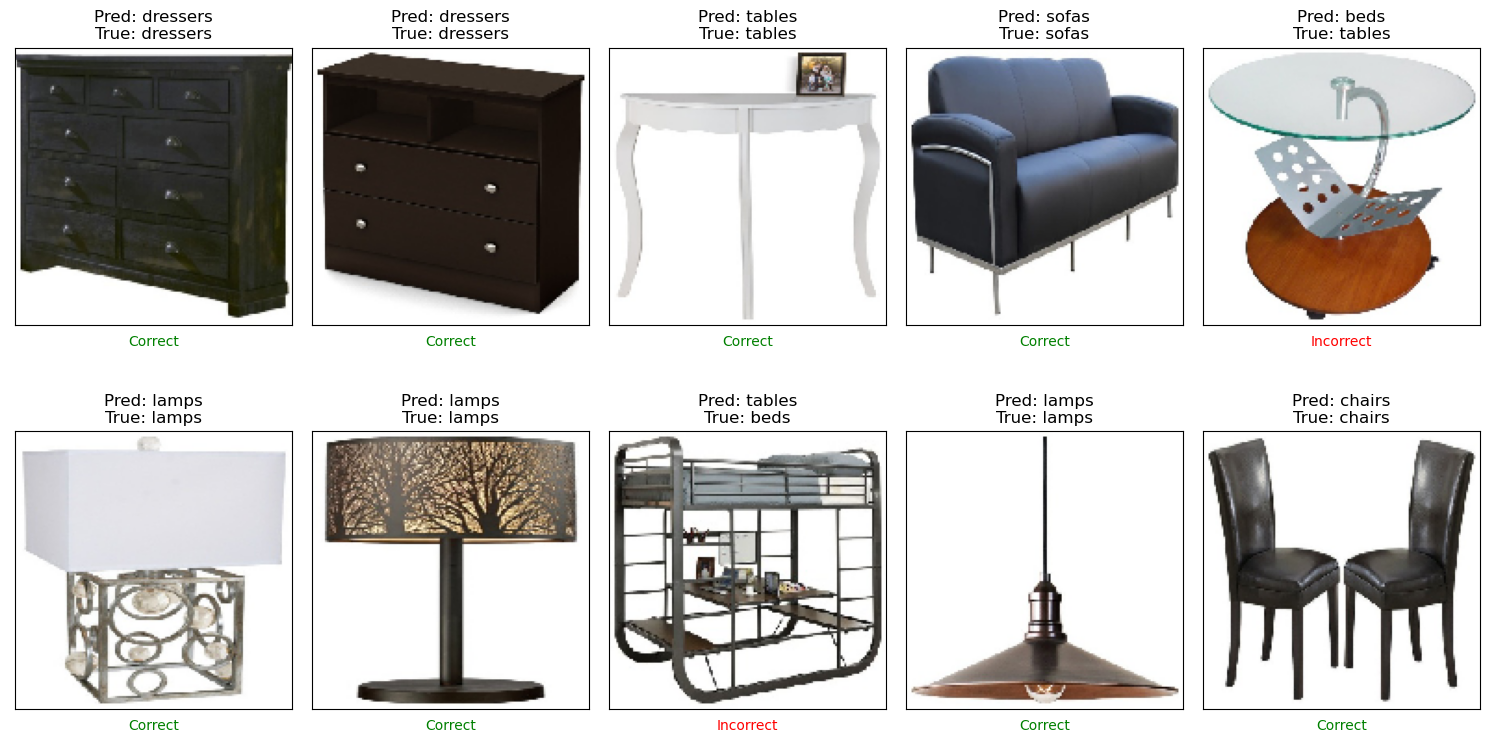

In [10]:
plt.figure(figsize=(15, 8))
for i, (image, truth, pred) in enumerate(zip(random_images, random_truth_labels, random_pred_labels)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Pred: {pred}\nTrue: {truth}")
    plt.xlabel("Correct" if pred == truth else "Incorrect", color="green" if pred == truth else "red")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()


## Image Query

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

def predict_single_image(image_path, model, target_size=(150, 150)):
    # Load and preprocess the image
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    img_array = img_to_array(img)  # Convert the image to a numpy array
    img_array = img_array / 255.0  # Normalize the image array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # # Load the model if given as a path
    # if isinstance(model, str):
    #     model = load_model(model)

    # Predict the class
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)

    # Optionally, decode the predictions
    # Assuming you have a mapping of class indices to labels
    class_labels = {0: 'beds', 1: 'chairs', 2: 'dressers', 3: 'lamps', 4: 'sofas', 5: 'tables'}
    predicted_label = class_labels[predicted_class[0]]

    # Display the image and the prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')  # Turn off axis labels
    plt.show()

    return predicted_label


1/1 [==============================] - 0s 18ms/step


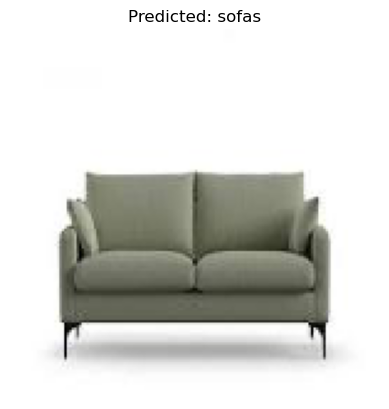

Predicted Label: sofas


In [14]:

image_path = './query_image/images.jpg'

# Call the function
predicted_label = predict_single_image(image_path, model)
print("Predicted Label:", predicted_label)
